In [92]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN



In [93]:
# Load the new dataset
df = pd.read_csv('Fraud Dataset_NEW.csv')

# Drop rows with missing values
df = df.dropna()
# Convert categorical data to numeric values using LabelEncoder
label_encoders = {}
for col in ["type", "isFraud","nameOrig", "nameDest", "branch", "Acct type", "Date of transaction", "Time of day", "DayOfWeek", "DayOfWeek(new)"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

scaler = StandardScaler()
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


# Display the first few rows of the transformed dataset
print(df.head())
print(df.describe().round(2))


       step  type  branch    amount  nameOrig  oldbalanceOrg  newbalanceOrig  \
0  1.120083     3      39 -0.381788      4776      -0.416752       -0.417682   
1  1.120083     3      51 -0.381443      8530      -0.416752       -0.417682   
2  1.120083     3      55 -0.366426      6610      -0.416752       -0.417682   
3  1.120083     3      40 -0.379262       714      -0.416752       -0.417682   
4  1.120083     3      40 -0.384378       687      -0.416752       -0.417682   

   nameDest  oldbalanceDest  newbalanceDest  unusuallogin  isFlaggedFraud  \
0      1789       -0.348586       -0.363802     -0.605099             0.0   
1      4374       -0.348586       -0.363802     -1.465773             0.0   
2      2139       -0.348586       -0.363802     -1.293638             0.0   
3      5488       -0.348586       -0.363802      0.427709             0.0   
4      5772       -0.348586       -0.363802     -0.605099             0.0   

   Acct type  Date of transaction  Time of day  isFraud 

In [94]:
from sklearn.ensemble import GradientBoostingClassifier

# Prepare data for supervised learning
X = df.drop(columns=["isFraud", "isFlaggedFraud"], errors='ignore')
y = df["isFraud"]

# Split the data into training and testing sets for supervised learning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



clf_gb = GradientBoostingClassifier(
    n_estimators=10,  # Reduce the number of trees
    learning_rate=0.5,  # Increase the learning rate
    max_depth=2,  # Reduce the maximum depth of trees
    random_state=42
)
clf_gb.fit(X_train, y_train)

y_pred = clf_gb.predict(X_test)

print("Supervised Learning")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Supervised Learning
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00      2004

    accuracy                           1.00      2018
   macro avg       1.00      1.00      1.00      2018
weighted avg       1.00      1.00      1.00      2018

[[  14    0]
 [   0 2004]]


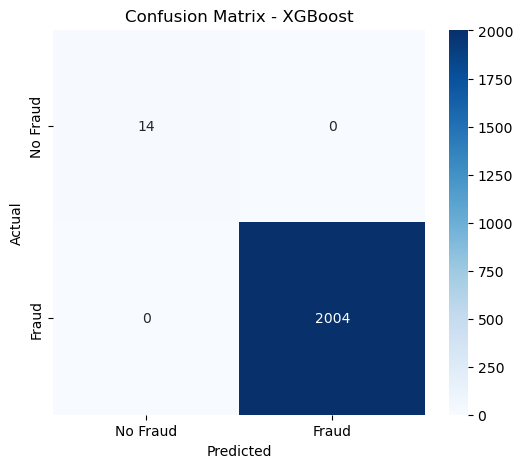

In [95]:
# Plot confusion matrix
plt.figure(figsize=(6,5))
cm_xgb = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [96]:
iso_forest = IsolationForest(contamination=0.1, random_state=42)
df["fraud_prediction"] = iso_forest.fit_predict(X)
df["fraud_prediction"] = df["fraud_prediction"].apply(lambda x: 1 if x == -1 else 0)#0=normal, 1=fraud



Cluster
-1    10088
Name: count, dtype: int64


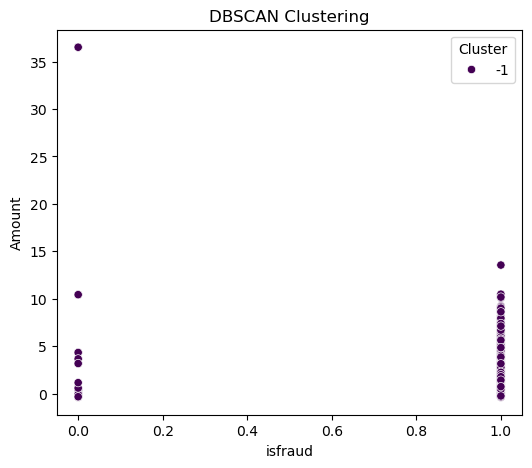

In [97]:

dbscan = DBSCAN(eps=0.5, min_samples=5)
df['Cluster'] = dbscan.fit_predict(df.drop(columns=["isFraud", "isFlaggedFraud", "fraud_prediction"], errors='ignore'))

print(df['Cluster'].value_counts())

plt.figure(figsize=(6,5))
sns.scatterplot(data=df, x="isFraud", y="amount", hue="Cluster", palette="viridis")
plt.xlabel("isfraud")
plt.ylabel("Amount")
plt.title("DBSCAN Clustering")
plt.show()


In [98]:
# Reverse the normalization of numerical columns
df[numerical_columns] = scaler.inverse_transform(df[numerical_columns])

# Reverse the label encoding for categorical columns
for col, le in label_encoders.items():
    if df[col].dtype == 'float64':
        df[col] = df[col].astype(int)
    df[col] = le.inverse_transform(df[col])

print(df.head())
print(df.describe().round(2))

   step     type          branch   amount     nameOrig  oldbalanceOrg  \
0   7.0  PAYMENT          Espana  1526.50  C1908839976            0.0   
1   7.0  PAYMENT        Honduras  1620.17    C70432899            0.0   
2   7.0  PAYMENT       Indonesia  5689.82   C332151172            0.0   
3   7.0  PAYMENT  Estados Unidos  2211.07  C1148172078            0.0   
4   7.0  PAYMENT  Estados Unidos   824.63  C1142006014            0.0   

   newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  ...  \
0             0.0  M1304522697             0.0             0.0  ...   
1             0.0   M252297858             0.0             0.0  ...   
2             0.0  M1430674428             0.0             0.0  ...   
3             0.0   M650835126             0.0             0.0  ...   
4             0.0   M745868137             0.0             0.0  ...   

   Acct type  Date of transaction Time of day isFraud Column1 isFraud - Copy  \
0    Savings            03-Jan-18   Afternoon    Safe 

In [99]:
df.to_csv('Traineddata3.csv', index=False)